In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.axis import Axis
import datetime as dt

import time
start = time.time()

In [2]:
def get_data2(filename):    
    data = pd.read_csv(filename) #, names=["Interval","kWh"])
    return data

In [3]:
def conso_byhour(day):
    ''' 
    display conso by hour for the chosen day
    '''
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))

    conso_hours = conso_day.copy()
    conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
    conso_hours#.info()
    # group by hour
    groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
    groupedbyhour.count()
    len(groupedbyhour)
    x = np.arange(1,len(groupedbyhour)+1)

    #groupedbyhour.count().plot(grid=True,xticks=x)
    plt.figure(figsize=(12, 8),facecolor='darkcyan')
    values = groupedbyhour.count().kWh
    #ax = plt.bar(x,groupedbyhour.count().kWh)
    ax = values.plot(kind="bar",color='green',width=.8)
    ax.set_facecolor('antiquewhite')
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) - {day}')
    plt.xlim(-1,len(x)+1)
    plt.xticks(rotation=30);
    
    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in values]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom",
            fontfamily='calibri', fontsize=16, fontweight='bold', color='blue'
        )
    
    
def from_csv(csv_file): 
    ''' save data to csv  '''
    df = pd.read_csv(csv_file)
    return df
    
def to_csv(csv_file, df):
    ''' read data from csv'''
    df.to_csv(csv_file, index=False)

def period(p=1):
    ''' 
    give the time of conso for a 1kWh window in a day
    p =  ordinal window ex: p=1 first kWh, p=2 second kWh ..
    df is the data from midnight, each entry is 1 watt
    as the length of df is the total conso in watt,
    we have len(df)/1000 = number of windows of 1 KWh since midnight
    the last window may not be 1000 watt long !
    '''
    if p==1:
        start = df.iloc[0].dates
    else:
        start = df.iloc[(p-1)*1000-1].dates
    if len(df)>p*1000:
        end = df.iloc[p*1000-1].dates
        conso = p*1000
    else:
        end = df.iloc[len(df)-1].dates
        conso = len(df) - (p-1)*1000
    period = end - start  # type timedelta
    hours = int(period / dt.timedelta(hours=1))
    mins = int(period / dt.timedelta(minutes=1)) - hours*60
    secs = int(period / dt.timedelta(seconds=1)) - hours*3600 - mins*60

    #df.iloc[1001:2000]['dates']#.tail(1)
    #print(period)
    print(f'{start}\t{end}\t{hours}h {mins}m {secs}s \t{conso}')


### conso.csv créé par pi4 node-red onglet Linky

In [4]:
conso_file = r"\\192.168.0.175\pihome\Documents\conso2.csv"
conso_data = get_data2(conso_file)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1763401 entries, 0 to 1763400
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Interval  int64  
 1   kWh       float64
dtypes: float64(1), int64(1)
memory usage: 26.9 MB


In [5]:
conso_data['kWh']

0          0.16
1          0.16
2          0.16
3          0.16
4          0.16
           ... 
1763396    0.13
1763397    0.14
1763398    0.14
1763399    0.14
1763400    0.14
Name: kWh, Length: 1763401, dtype: float64

In [6]:
conso_data['kWh']

0          0.16
1          0.16
2          0.16
3          0.16
4          0.16
           ... 
1763396    0.13
1763397    0.14
1763398    0.14
1763399    0.14
1763400    0.14
Name: kWh, Length: 1763401, dtype: float64

In [7]:
l=len(conso_data)-1
l

1763400

In [8]:
conso_data['sec']=conso_data['Interval']/1000


In [9]:
conso_data['Wh']=3600000/conso_data['Interval']


In [10]:
conso_data['cumul(ms)']=conso_data['Interval'].cumsum(axis=0)

In [11]:
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1763401 entries, 0 to 1763400
Data columns (total 5 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Interval   int64  
 1   kWh        float64
 2   sec        float64
 3   Wh         float64
 4   cumul(ms)  int64  
dtypes: float64(3), int64(2)
memory usage: 67.3 MB


In [12]:
conso_data.tail()

,Interval,kWh,sec,Wh,cumul(ms)
1763396,27188,0.13,27.188,132.411358,43419253556
1763397,26550,0.14,26.550,135.593220,43419280106
1763398,26459,0.14,26.459,136.059564,43419306565
1763399,26625,0.14,26.625,135.211268,43419333190
1763400,25602,0.14,25.602,140.614015,43419358792


In [13]:
cumtime= int(conso_data._get_value(l,'cumul(ms)')*1000)  # convert to microseconds
cumtime

43419358792000

In [14]:
from datetime import datetime, timedelta
now = datetime.now()
# conso.csv dynamique
base = now - timedelta(microseconds=cumtime)
base  # date de début

datetime.datetime(2023, 8, 21, 20, 18, 50, 677141)

In [15]:
conso_data['cumul(ms)'][conso_data['cumul(ms)'].isna()==True]

Series([], Name: cumul(ms), dtype: int64)

In [16]:
conso_data.iloc[0]


Interval     21934.00000
kWh              0.16000
sec             21.93400
Wh             164.12875
cumul(ms)    21934.00000
Name: 0, dtype: float64

# Recréer les dates à partir des cumuls par impulsion


In [17]:
base

datetime.datetime(2023, 8, 21, 20, 18, 50, 677141)

In [18]:
# create column 'dates' with time cumulated time from base
conso_data['dates'] = [base + dt.timedelta(microseconds=t*1000) for t in conso_data['cumul(ms)']]
conso_data['dates']

0         2023-08-21 20:19:12.611141
1         2023-08-21 20:19:34.469141
2         2023-08-21 20:19:56.470141
3         2023-08-21 20:20:18.398141
4         2023-08-21 20:20:40.289141
                     ...            
1763396   2025-01-05 09:13:04.233141
1763397   2025-01-05 09:13:30.783141
1763398   2025-01-05 09:13:57.242141
1763399   2025-01-05 09:14:23.867141
1763400   2025-01-05 09:14:49.469141
Name: dates, Length: 1763401, dtype: datetime64[ns]

## créer les dates

In [19]:
# create column 'days' avec format 'dd/mm/yy'
conso_data['days']= [d.strftime('%d/%m/%y') for d in conso_data['dates']]    
#[str(d.month)+'-'+str(d.day) for d in conso_data['dates']]
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,21934,0.16,21.934,164.128750,21934,2023-08-21 20:19:12.611141,21/08/23
1,21858,0.16,21.858,164.699424,43792,2023-08-21 20:19:34.469141,21/08/23
2,22001,0.16,22.001,163.628926,65793,2023-08-21 20:19:56.470141,21/08/23
3,21928,0.16,21.928,164.173659,87721,2023-08-21 20:20:18.398141,21/08/23
4,21891,0.16,21.891,164.451144,109612,2023-08-21 20:20:40.289141,21/08/23
...,...,...,...,...,...,...,...
1763396,27188,0.13,27.188,132.411358,43419253556,2025-01-05 09:13:04.233141,05/01/25
1763397,26550,0.14,26.550,135.593220,43419280106,2025-01-05 09:13:30.783141,05/01/25
1763398,26459,0.14,26.459,136.059564,43419306565,2025-01-05 09:13:57.242141,05/01/25
1763399,26625,0.14,26.625,135.211268,43419333190,2025-01-05 09:14:23.867141,05/01/25


### save conso_data with dates

In [20]:
#to_csv(r'../conso_data_with_dates.csv',conso_data)

# tranche journalière


In [21]:
now = datetime.now()
month = now.month
year = now.year
date = now.day
today = now.strftime('%d/%m/%y')    #str(now.month)+'-'+str(now.day)
today, date, month, year


('05/01/25', 5, 1, 2025)

In [22]:
here = now.strftime('%H:%M:%S')
here

'09:15:22'

In [23]:
conso_day = conso_data[conso_data['days']==today]
# save to file
filename='conso_jour.csv'
conso_day.to_csv(filename)
filename='../conso_jour.csv'
conso_day.to_csv(filename)

In [24]:
conso_day.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1115 entries, 1762286 to 1763400
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1115 non-null   int64         
 1   kWh        1115 non-null   float64       
 2   sec        1115 non-null   float64       
 3   Wh         1115 non-null   float64       
 4   cumul(ms)  1115 non-null   int64         
 5   dates      1115 non-null   datetime64[ns]
 6   days       1115 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 69.7+ KB


In [25]:
# group by day
grouped = conso_data[['days','kWh']].groupby('days', sort=False)
'''conso_graph=[]
for name, group in grouped:
    if name=='01/04/2024':print(group)
    #print("\n", name, len(group)/1000)
    conso_graph.append((name,len(group)/1000))'''
#grouped
# count elements in each group => conso in watts => convert to kW
df_grp = grouped.count()/1000



In [26]:
data = list(df_grp['kWh'])
print(data)

[0.679, 3.7, 4.221, 3.688, 4.025, 4.629, 3.639, 3.444, 3.507, 3.698, 3.586, 3.975, 4.259, 3.64, 3.625, 3.64, 3.321, 3.374, 4.14, 4.028, 4.016, 4.057, 3.481, 4.335, 3.86, 3.754, 4.175, 4.708, 3.982, 3.216, 3.172, 3.895, 3.779, 3.109, 3.785, 4.161, 3.666, 3.675, 4.666, 4.276, 4.465, 3.823, 3.446, 4.298, 3.874, 3.83, 3.48, 4.034, 3.695, 3.411, 4.157, 3.376, 3.854, 3.86, 3.628, 3.751, 4.278, 3.274, 3.88, 3.078, 2.055, 2.041, 2.375, 4.075, 3.676, 4.35, 3.588, 3.962, 3.756, 3.792, 4.122, 4.058, 3.709, 3.128, 3.766, 3.568, 3.566, 3.713, 3.674, 3.317, 3.834, 3.253, 3.754, 3.606, 4.073, 3.61, 3.432, 3.719, 4.112, 4.335, 3.934, 4.148, 4.279, 3.78, 3.925, 3.82, 3.909, 3.713, 4.043, 4.397, 3.886, 3.508, 3.674, 3.677, 3.346, 3.844, 3.962, 4.135, 3.514, 4.158, 3.596, 3.953, 4.642, 3.629, 3.516, 3.55, 4.045, 3.83, 4.084, 3.971, 3.743, 3.6, 5.101, 3.744, 3.759, 4.225, 4.154, 4.531, 4.427, 4.131, 3.658, 4.389, 4.751, 4.124, 4.776, 4.398, 3.688, 4.098, 3.83, 3.694, 3.484, 3.958, 3.686, 3.705, 3.649, 3.4

In [27]:
# save to file
import pickle
path = r'kwh_mean.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

In [28]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
def show(day,pltcolor='darkcyan',bgcolor="ivory"):
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
    #=[x.hour for x in conso_day['dates']]
    df = conso_day.set_index('heure')
    here = now.strftime('%H:%M:%S')
    conso_jour=len(df['kWh'])
    here, len(df)/1000, conso_jour

    # consommation d'une journée entière à partir de minuit
    # Set background color of the outer 
    # area of the plt
    #plt.figure(facecolor=fgcolor)
    fig, ax = plt.subplots(facecolor=pltcolor)
    
    major_ticks=300;minor_ticks=100
    ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  # major ticks tous les 15 min
    ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
    # the size of A4 paper
    fig.set_size_inches(10, 5)
    
    # set bg color
    ax.set_facecolor(bgcolor)
    plt.plot(df['kWh'])
    #plt.plot(conso_day['heure'],conso_day['kWh'])
    plt.title(f'Journée du {day} {here} : {conso_jour/1000} kwh')
    plt.grid()
    plt.xticks(rotation=30);


In [29]:
df = conso_data
len(df)

1763401

In [30]:
period(p=2)

2023-08-22 02:25:26.414141	2023-08-22 09:29:42.034141	7h 4m 15s 	2000


In [31]:
# mean of all instant conso
total_mean = conso_data[['kWh']].mean()
total_mean

kWh    0.296217
dtype: float64

In [32]:
mean=(grouped.count()/1000).mean()
mean

kWh    3.498812
dtype: float64

In [33]:
last=df_grp.iloc[-1]['kWh']
last

1.115

In [34]:
conso_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1115 entries, 1762286 to 1763400
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1115 non-null   int64         
 1   kWh        1115 non-null   float64       
 2   sec        1115 non-null   float64       
 3   Wh         1115 non-null   float64       
 4   cumul(ms)  1115 non-null   int64         
 5   dates      1115 non-null   datetime64[ns]
 6   days       1115 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 69.7+ KB


In [35]:
# select day
day = today
#day = '16/08/24'


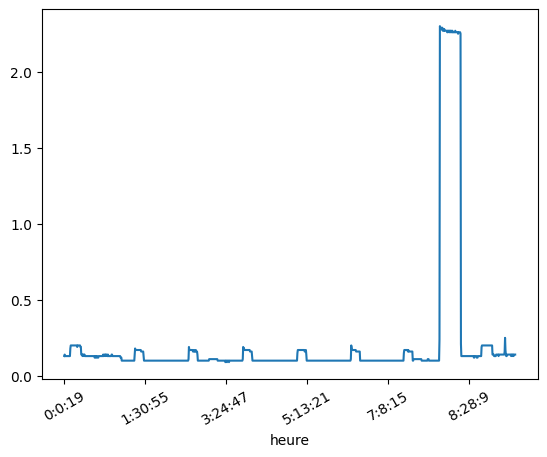

In [36]:
conso_day=conso_data[conso_data['days']==day].copy()  # no more error
conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
#=[x.hour for x in conso_day['dates']]
df= conso_day.set_index('heure')
df.tail(2000)['kWh'].plot()
plt.xticks(rotation=30);
#conso_day['heure']


In [37]:
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,21934,0.16,21.934,164.128750,21934,2023-08-21 20:19:12.611141,21/08/23
1,21858,0.16,21.858,164.699424,43792,2023-08-21 20:19:34.469141,21/08/23
2,22001,0.16,22.001,163.628926,65793,2023-08-21 20:19:56.470141,21/08/23
3,21928,0.16,21.928,164.173659,87721,2023-08-21 20:20:18.398141,21/08/23
4,21891,0.16,21.891,164.451144,109612,2023-08-21 20:20:40.289141,21/08/23
...,...,...,...,...,...,...,...
1763396,27188,0.13,27.188,132.411358,43419253556,2025-01-05 09:13:04.233141,05/01/25
1763397,26550,0.14,26.550,135.593220,43419280106,2025-01-05 09:13:30.783141,05/01/25
1763398,26459,0.14,26.459,136.059564,43419306565,2025-01-05 09:13:57.242141,05/01/25
1763399,26625,0.14,26.625,135.211268,43419333190,2025-01-05 09:14:23.867141,05/01/25


In [38]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
heure,,,,,,,
0:0:19,28211,0.13,28.211,127.609798,43386089308,2025-01-05 00:00:19.985141,05/01/25
0:0:45,25703,0.14,25.703,140.061471,43386115011,2025-01-05 00:00:45.688141,05/01/25
0:1:12,27145,0.13,27.145,132.621109,43386142156,2025-01-05 00:01:12.833141,05/01/25
0:1:40,27853,0.13,27.853,129.249991,43386170009,2025-01-05 00:01:40.686141,05/01/25
0:2:8,28116,0.13,28.116,128.040973,43386198125,2025-01-05 00:02:08.802141,05/01/25
...,...,...,...,...,...,...,...
9:13:4,27188,0.13,27.188,132.411358,43419253556,2025-01-05 09:13:04.233141,05/01/25
9:13:30,26550,0.14,26.550,135.593220,43419280106,2025-01-05 09:13:30.783141,05/01/25
9:13:57,26459,0.14,26.459,136.059564,43419306565,2025-01-05 09:13:57.242141,05/01/25


In [39]:
# group by hour, df  = data of a chosen day
df_byhour = df[['days','kWh']].groupby('heure', sort=False)
kwh_byhour = df_byhour['kWh']



Max : 23/12/24 5.075
Min : 21/12/24 3.006


,Interval,kWh,sec,Wh,cumul(ms),dates,days,heure
1762286,28211,0.13,28.211,127.609798,43386089308,2025-01-05 00:00:19.985141,05/01/25,0:0:19
1762287,25703,0.14,25.703,140.061471,43386115011,2025-01-05 00:00:45.688141,05/01/25,0:0:45
1762288,27145,0.13,27.145,132.621109,43386142156,2025-01-05 00:01:12.833141,05/01/25,0:1:12
1762289,27853,0.13,27.853,129.249991,43386170009,2025-01-05 00:01:40.686141,05/01/25,0:1:40
1762290,28116,0.13,28.116,128.040973,43386198125,2025-01-05 00:02:08.802141,05/01/25,0:2:8
...,...,...,...,...,...,...,...,...
1763396,27188,0.13,27.188,132.411358,43419253556,2025-01-05 09:13:04.233141,05/01/25,9:13:4
1763397,26550,0.14,26.550,135.593220,43419280106,2025-01-05 09:13:30.783141,05/01/25,9:13:30
1763398,26459,0.14,26.459,136.059564,43419306565,2025-01-05 09:13:57.242141,05/01/25,9:13:57
1763399,26625,0.14,26.625,135.211268,43419333190,2025-01-05 09:14:23.867141,05/01/25,9:14:23


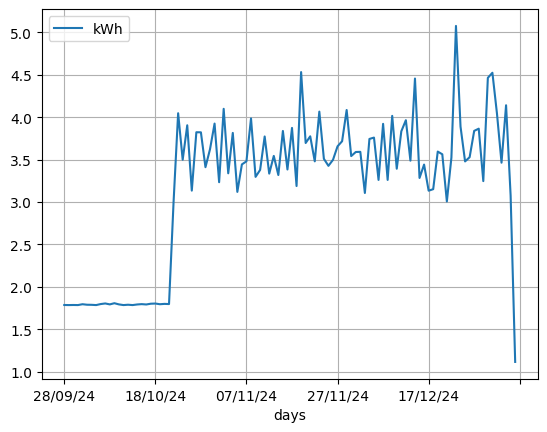

In [40]:

# premier kWh
if len(df)>1000:
    df.iloc[1000]['dates']
df.iloc[0].dates
df.dates.dt.time

# save data
df_grp.to_csv('df_grp.csv')
df.to_csv('df.csv')
df_grp.to_csv('conso_day_from_20230821.csv')

#df.info()
#df_grp.info()
df_grp.mean()
#df_grp.head()
df_grp.tail(14)
df_grp.tail(100).mean()
df_grp.tail(100).plot()
plt.grid()
# max min during last month
#print(df_grp.iloc[-31:-1])
df_grp.iloc[-31:-1].describe()

month = df_grp.iloc[-31:-1]['kWh']
print('Max :',month.idxmax(), max(month))
print('Min :',month.idxmin(), min(month))
conso_day


2025-01-05 00:00:19.985141	2025-01-05 08:27:41.205141	8h 27m 21s 	1000
2025-01-05 08:27:41.205141	2025-01-05 09:14:49.469141	0h 47m 8s 	115
<class 'pandas.core.frame.DataFrame'>
Index: 1115 entries, 1762286 to 1763400
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1115 non-null   int64         
 1   kWh        1115 non-null   float64       
 2   sec        1115 non-null   float64       
 3   Wh         1115 non-null   float64       
 4   cumul(ms)  1115 non-null   int64         
 5   dates      1115 non-null   datetime64[ns]
 6   days       1115 non-null   object        
 7   heure      1115 non-null   object        
 8   hours      1115 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 87.1+ KB


('05/01/25', <Axes: xlabel='hours'>)

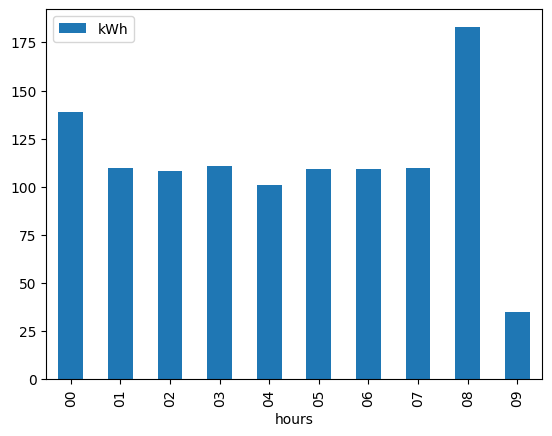

In [41]:

tranches = len(df)//1000
tranches+1
# temps de conso par tranches de 1kwh
for p in range(1,tranches+2):  # les 5 tranches de kWh consommés
    if len(df)>(p-1)*1000:
        period(p)
# conso temps réel
here = now.strftime('%H:%M:%S')
conso_jour=len(df['kWh'])
here, len(df)/1000, conso_jour
#add hours column for a chosen day
conso_hours = conso_day.copy()
conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
conso_hours.info()

conso_hours
# group conso of the day by hour
groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
list(groupedbyhour)
day, groupedbyhour.count().plot.bar()

In [42]:
df_grp

,kWh
days,
21/08/23,0.679
22/08/23,3.700
23/08/23,4.221
24/08/23,3.688
25/08/23,4.025
...,...
01/01/25,4.043
02/01/25,3.463
03/01/25,4.140


In [43]:
# select number of days to display
span = 30
#df_grp.tail(span)


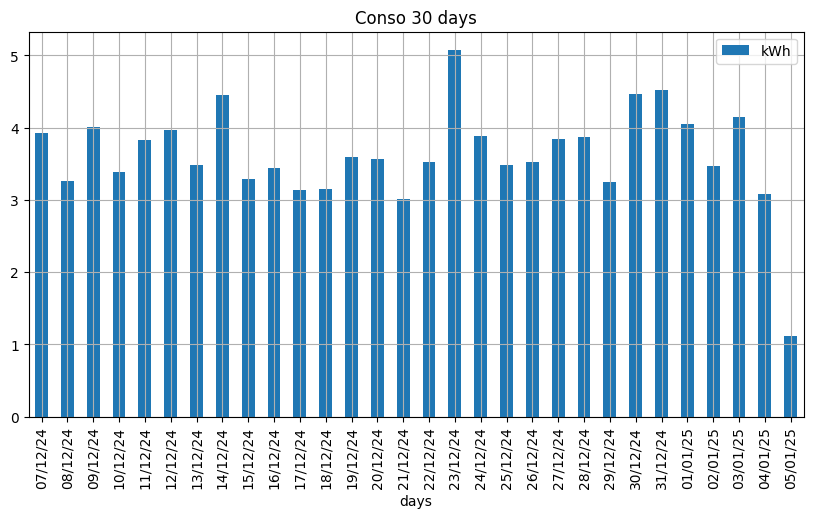

In [44]:

# Plot the figure without labels
df_grp.tail(span).plot.bar(grid=True, figsize=(10, 5), layout='tight') 
plt.title(f'Conso {span} days')
plt.xticks(rotation=90);


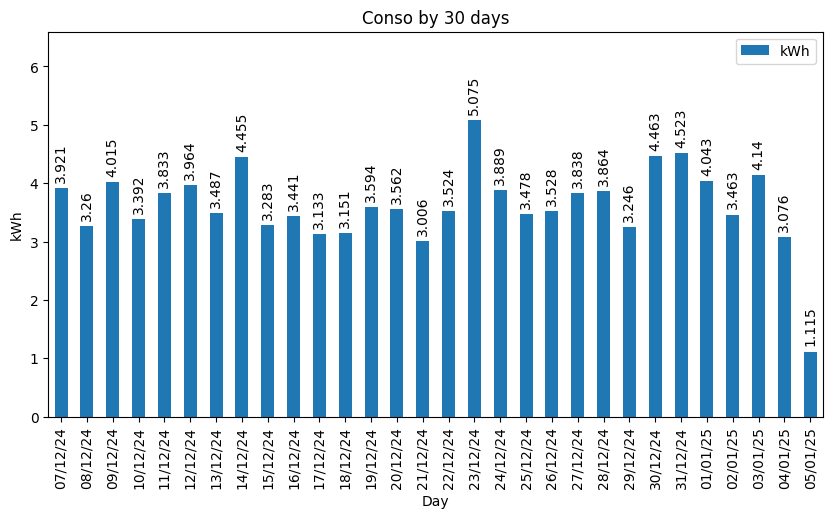

In [45]:
# Plot the figure with labels.
x_labels = list(df_grp.tail(span)['kWh'])
#x_labels
#fig, ax = plt.subplots(figsize=(2, 2), facecolor='lightskyblue',layout='constrained')
ax = df_grp.tail(span).plot(kind="bar", figsize=(10, 5), layout='tight')
ax.set_title(f"Conso by {span} days")
ax.set_xlabel("Day")
ax.set_ylabel("kWh")
ax.set_ymargin(0.3)
#ax.set_xticklabels(x_labels)
#fig.tight_layout()

rects = ax.patches

# Make some labels.
labels = [x_labels[i] for i in range(len(x_labels))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    #print(height)
    ax.text(
        rect.get_x() + rect.get_width() / 2, height+.1, label, ha="center", va="bottom", rotation=90
    )

#plt.show()

In [46]:
y_labels = df_grp.tail(span)['kWh']
y_labels

days
07/12/24    3.921
08/12/24    3.260
09/12/24    4.015
10/12/24    3.392
11/12/24    3.833
12/12/24    3.964
13/12/24    3.487
14/12/24    4.455
15/12/24    3.283
16/12/24    3.441
17/12/24    3.133
18/12/24    3.151
19/12/24    3.594
20/12/24    3.562
21/12/24    3.006
22/12/24    3.524
23/12/24    5.075
24/12/24    3.889
25/12/24    3.478
26/12/24    3.528
27/12/24    3.838
28/12/24    3.864
29/12/24    3.246
30/12/24    4.463
31/12/24    4.523
01/01/25    4.043
02/01/25    3.463
03/01/25    4.140
04/01/25    3.076
05/01/25    1.115
Name: kWh, dtype: float64

In [47]:
x_labels=df_grp.tail(span).index
x_labels

Index(['07/12/24', '08/12/24', '09/12/24', '10/12/24', '11/12/24', '12/12/24',
       '13/12/24', '14/12/24', '15/12/24', '16/12/24', '17/12/24', '18/12/24',
       '19/12/24', '20/12/24', '21/12/24', '22/12/24', '23/12/24', '24/12/24',
       '25/12/24', '26/12/24', '27/12/24', '28/12/24', '29/12/24', '30/12/24',
       '31/12/24', '01/01/25', '02/01/25', '03/01/25', '04/01/25', '05/01/25'],
      dtype='object', name='days')

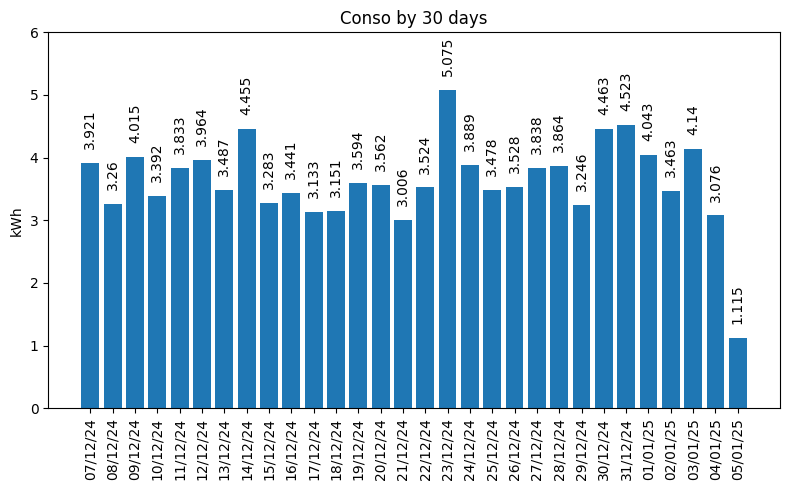

In [48]:
# Plot the figure with labels
# using bar_label
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')
bar_container = ax.bar(x_labels, y_labels)
#ax.set_xticks(x_labels, rotation=45)
ax.bar_label(bar_container, rotation=90, padding=10) #, fmt='{:,.0f}')
ax.set(ylabel='kWh', title=f'Conso by {span} days', ylim=(0, 6))
plt.xticks(rotation=90);


In [49]:
# figure manager

current=plt.get_current_fig_manager()
current.set_window_title('Conso by day')
#help(current.canvas)
#,facecolor='darkcyan')
#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
#plt.style.use('dark_background')


<Figure size 640x480 with 0 Axes>

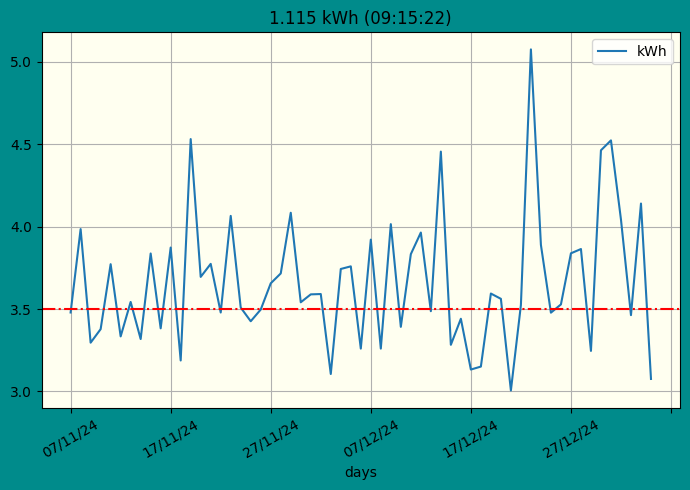

In [50]:
# pandas plot the day consos in the group
fig, ax = plt.subplots(facecolor='darkcyan', figsize=(7, 5), layout='tight')  # as argument
#or fig.patch.set_facecolor('darkcyan') # This changes the grey to white
ax.set_facecolor("ivory")

# 2 last months
df_grp.iloc[-60:-1].plot(grid=True,ax=ax, y=["kWh"])   #df.plot(x="Name", y=["Age", "Height(in cm)"], kind="bar", ax=ax)
plt.title(str(last)+' kWh ('+str(here)+')')
plt.axhline(y=np.nanmean(df_grp),c='red', ls='-.')
plt.xticks(rotation=30);  # https://ipython.readthedocs.io/en/stable/interactive/tips.html


Text(0.5, 1.0, 'Variations journalières')

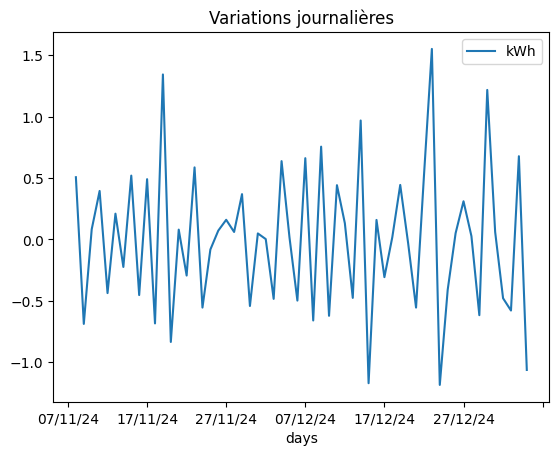

In [51]:
# variations journalières
df_grp.iloc[-60:-1].diff().plot()
plt.title('Variations journalières')

# Data from 21/08/23

In [52]:
# add hours column for conso_data (from 21/08/2023)
conso_days = conso_data.copy()
conso_days['hours']= conso_days['dates'].dt.strftime('%H')
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours
0,21934,0.16,21.934,164.128750,21934,2023-08-21 20:19:12.611141,21/08/23,20
1,21858,0.16,21.858,164.699424,43792,2023-08-21 20:19:34.469141,21/08/23,20
2,22001,0.16,22.001,163.628926,65793,2023-08-21 20:19:56.470141,21/08/23,20
3,21928,0.16,21.928,164.173659,87721,2023-08-21 20:20:18.398141,21/08/23,20
4,21891,0.16,21.891,164.451144,109612,2023-08-21 20:20:40.289141,21/08/23,20
...,...,...,...,...,...,...,...,...
1763396,27188,0.13,27.188,132.411358,43419253556,2025-01-05 09:13:04.233141,05/01/25,09
1763397,26550,0.14,26.550,135.593220,43419280106,2025-01-05 09:13:30.783141,05/01/25,09
1763398,26459,0.14,26.459,136.059564,43419306565,2025-01-05 09:13:57.242141,05/01/25,09
1763399,26625,0.14,26.625,135.211268,43419333190,2025-01-05 09:14:23.867141,05/01/25,09


In [53]:
# example groupby with apply
df = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                              'Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})
df.groupby("Animal", group_keys=True)[['Max Speed']].apply(lambda x: x)
      

Max Speed
Animal             
Falcon 0      380.0
       1      370.0
Parrot 2       24.0
       3       26.0

In [54]:
import pandas as pd
df = pd.read_csv(r'C:\Users\jean\Downloads\only-bh-extreme-events-satellite.csv'
                  ,index_col=[0,1,2,3,4]
                  ,header=[0,1,2,3]
                  ,skipinitialspace=True
                  #,tupleize_cols=True
                ) 

df.columns = pd.MultiIndex.from_tuples(df.columns)
df.index.names

FrozenList(['wsid', 'lat', 'lon', 'start', 'prcp_24'])

In [55]:
index=df.columns.levels[0]
index

Index(['al', 'asn', 'cc', 'chnk', 'ci', 'ciwc', 'clwc', 'd', 'd2m', 'hcc',
       'istl1', 'istl2', 'istl3', 'istl4', 'lcc', 'lsrh', 'mcc', 'msl', 'o3',
       'p53.162', 'p54.162', 'p55.162', 'p56.162', 'p57.162', 'p58.162',
       'p59.162', 'p60.162', 'p61.162', 'p62.162', 'p63.162', 'p64.162',
       'p65.162', 'p66.162', 'p67.162', 'p68.162', 'p69.162', 'p70.162',
       'p71.162', 'p72.162', 'p73.162', 'p74.162', 'p75.162', 'p76.162',
       'p77.162', 'p78.162', 'p79.162', 'p80.162', 'p81.162', 'p82.162',
       'p83.162', 'p84.162', 'p85.162', 'p86.162', 'p87.162', 'p88.162',
       'p89.162', 'p90.162', 'p91.162', 'p92.162', 'pv', 'q', 'r', 'rsn', 'sd',
       'skt', 'sp', 'sr', 'src', 'sst', 'stl1', 'stl2', 'stl3', 'stl4',
       'swvl1', 'swvl2', 'swvl3', 'swvl4', 't', 't2m', 'tcc', 'tco3', 'tcw',
       'tcwv', 'tsn', 'u', 'u10', 'v', 'v10', 'vo', 'w', 'z'],
      dtype='object')

In [56]:
df_des = pd.DataFrame(
                            index=df.columns.levels[0],
                            columns=['count','mean','std','min','25','50','75','max']
                         )
df_des

,count,mean,std,min,25,50,75,max
al,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
asn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
chnk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ci,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
v,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
v10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
w,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
groupallbyday = conso_days[['days','hours','kWh']].groupby(['days'], sort=False)
groupallbyday[['kWh']].count()  #.apply(lambda x: x))

,kWh
days,
21/08/23,679
22/08/23,3700
23/08/23,4221
24/08/23,3688
25/08/23,4025
...,...
01/01/25,4043
02/01/25,3463
03/01/25,4140


In [58]:
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours
0,21934,0.16,21.934,164.128750,21934,2023-08-21 20:19:12.611141,21/08/23,20
1,21858,0.16,21.858,164.699424,43792,2023-08-21 20:19:34.469141,21/08/23,20
2,22001,0.16,22.001,163.628926,65793,2023-08-21 20:19:56.470141,21/08/23,20
3,21928,0.16,21.928,164.173659,87721,2023-08-21 20:20:18.398141,21/08/23,20
4,21891,0.16,21.891,164.451144,109612,2023-08-21 20:20:40.289141,21/08/23,20
...,...,...,...,...,...,...,...,...
1763396,27188,0.13,27.188,132.411358,43419253556,2025-01-05 09:13:04.233141,05/01/25,09
1763397,26550,0.14,26.550,135.593220,43419280106,2025-01-05 09:13:30.783141,05/01/25,09
1763398,26459,0.14,26.459,136.059564,43419306565,2025-01-05 09:13:57.242141,05/01/25,09
1763399,26625,0.14,26.625,135.211268,43419333190,2025-01-05 09:14:23.867141,05/01/25,09


In [59]:

# group all by day for all conso_days
groupallbydayhours = conso_days[['days','hours','kWh']].groupby(['days','hours'], sort=False)
# use apply to show the group
groupallbydayhours[['days','hours','kWh']].apply(lambda x: x)


days hours   kWh
days     hours                              
21/08/23 20    0        21/08/23    20  0.16
               1        21/08/23    20  0.16
               2        21/08/23    20  0.16
               3        21/08/23    20  0.16
               4        21/08/23    20  0.16
...                          ...   ...   ...
05/01/25 09    1763396  05/01/25    09  0.13
               1763397  05/01/25    09  0.14
               1763398  05/01/25    09  0.14
               1763399  05/01/25    09  0.14
               1763400  05/01/25    09  0.14

[1763401 rows x 3 columns]

In [60]:
groupallbyday.indices.keys()

dict_keys(['21/08/23', '22/08/23', '23/08/23', '24/08/23', '25/08/23', '26/08/23', '27/08/23', '28/08/23', '29/08/23', '30/08/23', '31/08/23', '01/09/23', '02/09/23', '03/09/23', '04/09/23', '05/09/23', '06/09/23', '07/09/23', '08/09/23', '09/09/23', '10/09/23', '11/09/23', '12/09/23', '13/09/23', '14/09/23', '15/09/23', '16/09/23', '17/09/23', '18/09/23', '19/09/23', '20/09/23', '21/09/23', '22/09/23', '23/09/23', '24/09/23', '25/09/23', '26/09/23', '27/09/23', '28/09/23', '29/09/23', '30/09/23', '01/10/23', '02/10/23', '03/10/23', '04/10/23', '05/10/23', '06/10/23', '07/10/23', '08/10/23', '09/10/23', '10/10/23', '11/10/23', '12/10/23', '13/10/23', '14/10/23', '15/10/23', '16/10/23', '17/10/23', '18/10/23', '19/10/23', '20/10/23', '21/10/23', '22/10/23', '23/10/23', '24/10/23', '25/10/23', '26/10/23', '27/10/23', '28/10/23', '29/10/23', '30/10/23', '31/10/23', '01/11/23', '02/11/23', '03/11/23', '04/11/23', '05/11/23', '06/11/23', '07/11/23', '08/11/23', '09/11/23', '10/11/23', '11/1

In [61]:
groupallbydayhours.indices.keys()

dict_keys([('21/08/23', '20'), ('21/08/23', '21'), ('21/08/23', '22'), ('21/08/23', '23'), ('22/08/23', '20'), ('22/08/23', '21'), ('22/08/23', '22'), ('22/08/23', '23'), ('22/08/23', '00'), ('22/08/23', '01'), ('22/08/23', '02'), ('22/08/23', '03'), ('22/08/23', '04'), ('22/08/23', '05'), ('22/08/23', '06'), ('22/08/23', '07'), ('22/08/23', '08'), ('22/08/23', '09'), ('22/08/23', '10'), ('22/08/23', '11'), ('22/08/23', '12'), ('22/08/23', '13'), ('22/08/23', '14'), ('22/08/23', '15'), ('22/08/23', '16'), ('22/08/23', '17'), ('22/08/23', '18'), ('22/08/23', '19'), ('23/08/23', '20'), ('23/08/23', '21'), ('23/08/23', '22'), ('23/08/23', '23'), ('23/08/23', '00'), ('23/08/23', '01'), ('23/08/23', '02'), ('23/08/23', '03'), ('23/08/23', '04'), ('23/08/23', '05'), ('23/08/23', '06'), ('23/08/23', '07'), ('23/08/23', '08'), ('23/08/23', '09'), ('23/08/23', '10'), ('23/08/23', '11'), ('23/08/23', '12'), ('23/08/23', '13'), ('23/08/23', '14'), ('23/08/23', '15'), ('23/08/23', '16'), ('23/08/2

In [62]:
grp_by_day = groupallbyday.count()
grp_by_day

,hours,kWh
days,,
21/08/23,679,679
22/08/23,3700,3700
23/08/23,4221,4221
24/08/23,3688,3688
25/08/23,4025,4025
...,...,...
01/01/25,4043,4043
02/01/25,3463,3463
03/01/25,4140,4140


In [63]:
grp_by_day['kWh'].cumsum()

days
21/08/23        679
22/08/23       4379
23/08/23       8600
24/08/23      12288
25/08/23      16313
             ...   
01/01/25    1751607
02/01/25    1755070
03/01/25    1759210
04/01/25    1762286
05/01/25    1763401
Name: kWh, Length: 504, dtype: int64

In [64]:
grp_by_dayhours = groupallbydayhours.count()
grp_by_dayhours

kWh
days     hours     
21/08/23 20     127
         21     279
         22     143
         23     130
22/08/23 00     130
...             ...
05/01/25 05     109
         06     109
         07     110
         08     183
         09      35

[12062 rows x 1 columns]

In [65]:
grp_by_dayhours['kWh'].cumsum()

days      hours
21/08/23  20           127
          21           406
          22           549
          23           679
22/08/23  00           809
                    ...   
05/01/25  05       1762964
          06       1763073
          07       1763183
          08       1763366
          09       1763401
Name: kWh, Length: 12062, dtype: int64

In [66]:
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(level=0)['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(level=0)['kWh'].diff()
# or
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(['days'])['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(['days'])['kWh'].diff()
grp_by_dayhours

kWh  cumsum   diff
days     hours                    
21/08/23 20     127     127    NaN
         21     279     406  152.0
         22     143     549 -136.0
         23     130     679  -13.0
22/08/23 00     130     130    NaN
...             ...     ...    ...
05/01/25 05     109     678    8.0
         06     109     787    0.0
         07     110     897    1.0
         08     183    1080   73.0
         09      35    1115 -148.0

[12062 rows x 3 columns]

In [67]:
today, grp_by_dayhours.loc[today]

('05/01/25',
        kWh  cumsum   diff
 hours                    
 00     139     139    NaN
 01     110     249  -29.0
 02     108     357   -2.0
 03     111     468    3.0
 04     101     569  -10.0
 05     109     678    8.0
 06     109     787    0.0
 07     110     897    1.0
 08     183    1080   73.0
 09      35    1115 -148.0)

Text(0.5, 1.0, 'Cumul journalier')

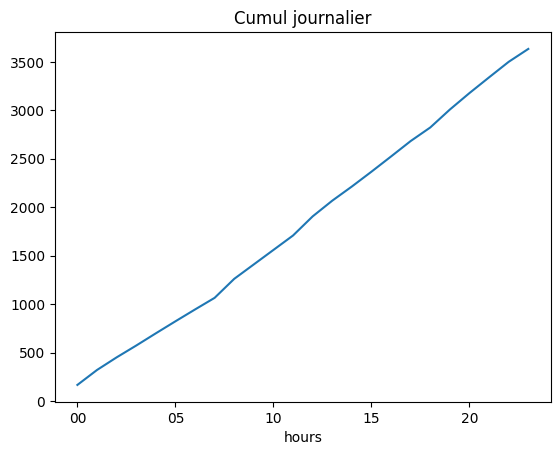

In [68]:
# progression sans surprise
grp_by_dayhours.loc['26/08/24']['cumsum'].plot()
plt.title('Cumul journalier')

Text(0.5, 1.0, 'Variation horaire')

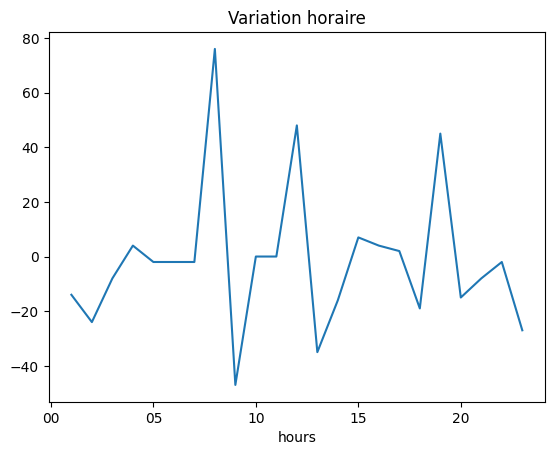

In [69]:
# plus parlant
grp_by_dayhours.loc['26/08/24']['diff'].plot()
plt.title(r'Variation horaire')

In [70]:
# count number of days since 21/08/2023
# https://stackoverflow.com/questions/45972388/count-my-multi-index-length-in-a-dataframe-pandas
n = len(grp_by_dayhours.index.levels[0].unique())
# or
n = len(grp_by_dayhours.index.levels[0])
# or
n = grp_by_dayhours.index.levshape[0]  # levshape -> (371,24)
n

504

In [71]:
df_grp.tail(n)['kWh'].describe()


count    504.000000
mean       3.498812
std        0.693205
min        0.679000
25%        3.338750
50%        3.621500
75%        3.880750
max        5.101000
Name: kWh, dtype: float64

In [72]:
maxday = df_grp.tail(n)['kWh'].idxmax()

Text(0.5, 1.0, '504 days')

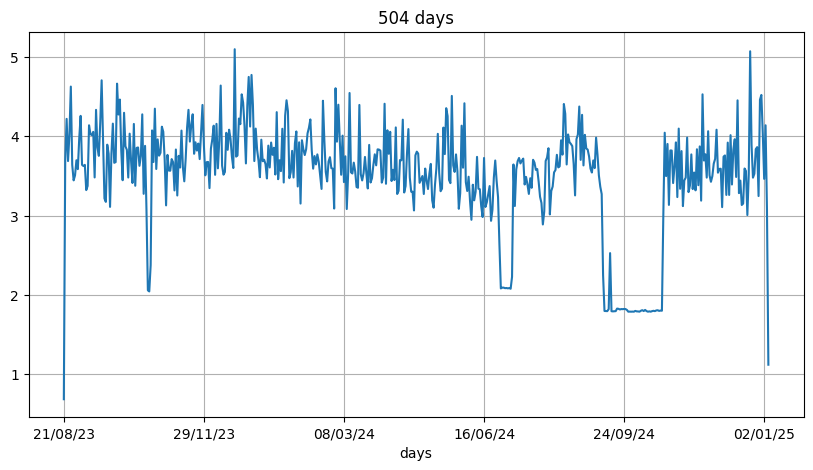

In [73]:
# show conso in span 
span = n
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')

Text(0.5, 1.0, '400 days')

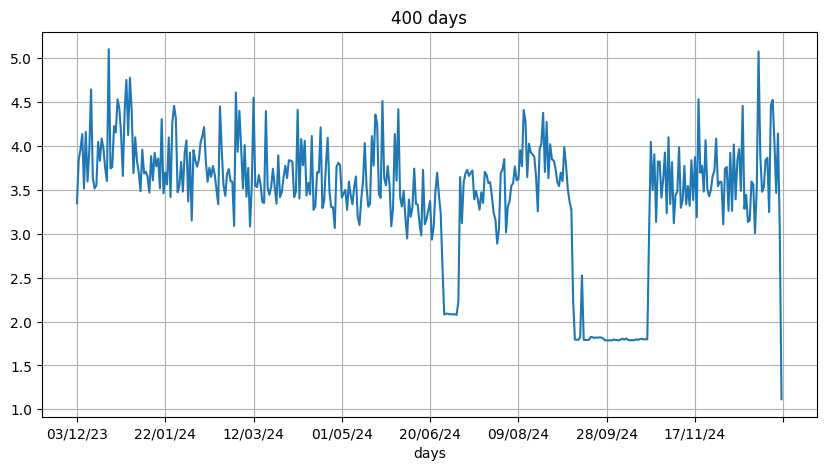

In [74]:
# show conso in span 
span = 400
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')

In [75]:
df_grp['kWh']

days
21/08/23    0.679
22/08/23    3.700
23/08/23    4.221
24/08/23    3.688
25/08/23    4.025
            ...  
01/01/25    4.043
02/01/25    3.463
03/01/25    4.140
04/01/25    3.076
05/01/25    1.115
Name: kWh, Length: 504, dtype: float64

In [76]:
df_grp.describe()

,kWh
count,504.000000
mean,3.498812
std,0.693205
min,0.679000
25%,3.338750
50%,3.621500
75%,3.880750
max,5.101000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

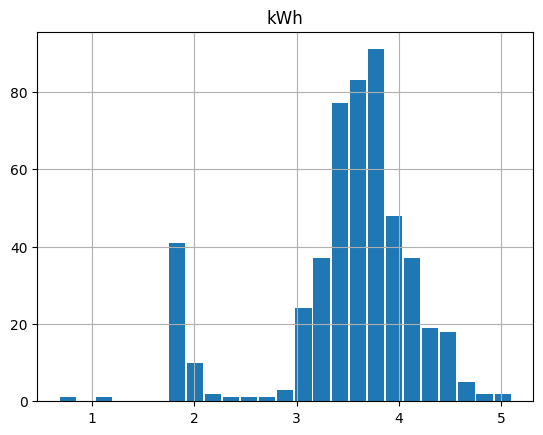

In [77]:
# répartition des consos de 1 à 5 kWh par jour
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
# histtype{'bar', 'barstacked', 'step', 'stepfilled'}, default: 'bar'
df_grp.hist(bins=25, density=False, histtype='bar',rwidth=0.9, align='mid')

In [78]:
df_grp.tail(span)['kWh']

days
03/12/23    3.346
04/12/23    3.844
05/12/23    3.962
06/12/23    4.135
07/12/23    3.514
            ...  
01/01/25    4.043
02/01/25    3.463
03/01/25    4.140
04/01/25    3.076
05/01/25    1.115
Name: kWh, Length: 400, dtype: float64

# Conso par heure

In [79]:
day

'05/01/25'

In [80]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff
hours,,,
00,139,139,NaN
01,110,249,-29.0
02,108,357,-2.0
03,111,468,3.0
04,101,569,-10.0
05,109,678,8.0
06,109,787,0.0
07,110,897,1.0
08,183,1080,73.0


In [81]:
# select a day to plot
day = '02/07/24'
day = today
len(grp_by_dayhours.loc[day])


10

In [82]:
l = range(1,len(grp_by_dayhours.loc[day])+1)
l

range(1, 11)

In [83]:
grp_by_dayhours.loc[day,'days'] = l #ist(1,len(grp_by_day.loc[day])+1)

In [84]:
grp_by_dayhours.loc[day,'days'].values

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [85]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
Name: days, dtype: float64

In [86]:
### ????????????????????????
grp_by_dayhours.loc[day,'days'] = grp_by_dayhours.loc[day,'days'].values.astype('int64')

In [87]:
grp_by_dayhours.loc[day].info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 00 to 09
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     10 non-null     int64  
 1   cumsum  10 non-null     int64  
 2   diff    9 non-null      float64
 3   days    10 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 400.0+ bytes


In [88]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
Name: days, dtype: float64

In [89]:
day

'05/01/25'

In [90]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff,days
hours,,,,
00,139,139,NaN,1.0
01,110,249,-29.0,2.0
02,108,357,-2.0,3.0
03,111,468,3.0,4.0
04,101,569,-10.0,5.0
05,109,678,8.0,6.0
06,109,787,0.0,7.0
07,110,897,1.0,8.0
08,183,1080,73.0,9.0


Text(0.5, 1.0, '05/01/25')

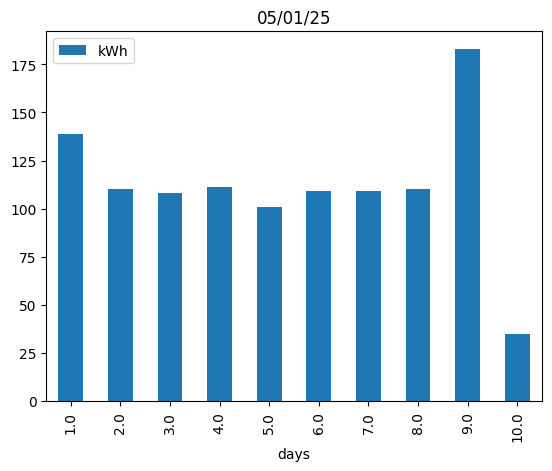

In [91]:
grp_by_dayhours.loc[day][['days','kWh']].plot.bar(x='days')
plt.title(f'{day}')

In [92]:
grp_by_dayhours.loc[day].index

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09'], dtype='object', name='hours')

# Conso du jour


In [93]:
groupedbyhour.count()

,kWh
hours,
00,139
01,110
02,108
03,111
04,101
05,109
06,109
07,110
08,183


In [94]:
day = '09/09/24'
day = maxday
#day = today
grp_by_dayhours.loc[day].kWh

hours
00    165
01    166
02    152
03    170
04    155
05    158
06    143
07    115
08    130
09    128
10    117
11    131
12    114
13    132
14    203
15    139
16    156
17    985
18    202
19    279
20    302
21    310
22    319
23    230
Name: kWh, dtype: int64

In [95]:
def conso_by_hour(day):
    global data
    # conso by hour
    #data = groupedbyhour.count().kWh
    data = grp_by_dayhours.loc[day].kWh

    # len(groupedbyhour)
    x = np.arange(1,len(data)+1)
    ymax = max(data)+5
    #groupedbyhour.count().plot(grid=True,xticks=x)
    fig, ax = plt.subplots(figsize=(8, 5), facecolor='darkcyan')

    plt.bar(x,data)
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) {day} - Total {sum(data)}')
    plt.xlim(0,len(x)+1)
    #plt.xticks(rotation=30);
    #plt.ylim(0,ymax)

    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in data]
    fontfamily = {'calibri', 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 3, label, ha="center", va="bottom",
            fontfamily=fontfamily, fontsize=10, fontweight='bold', color='red'
        )


# 100 days

317.424

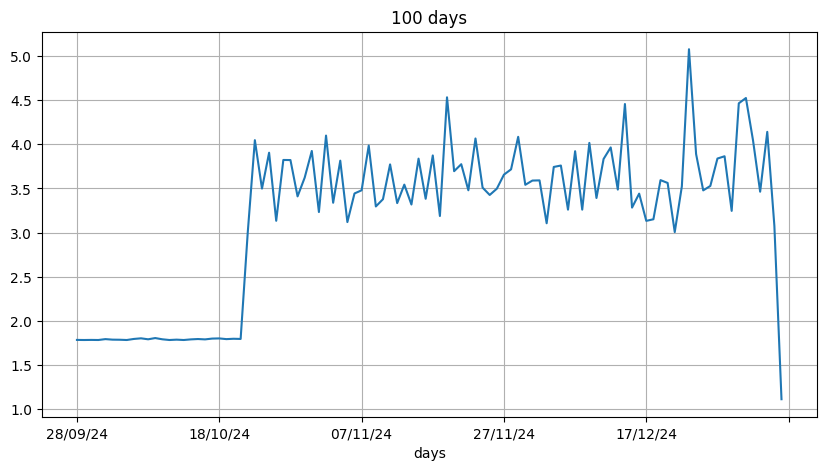

In [96]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')
sum(df_grp.tail(span)['kWh'])

In [97]:
df_grp.tail(1)

,kWh
days,
05/01/25,1.115


In [98]:
span = 1
#df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
#plt.title(f'{span} days')
sum(df_grp.tail(span)['kWh'])

1.115

In [99]:
#import timeit
#start = timeit.timeit()
#print("hello")
end = time.time()
print(end - start)

87.21025800704956


# Today

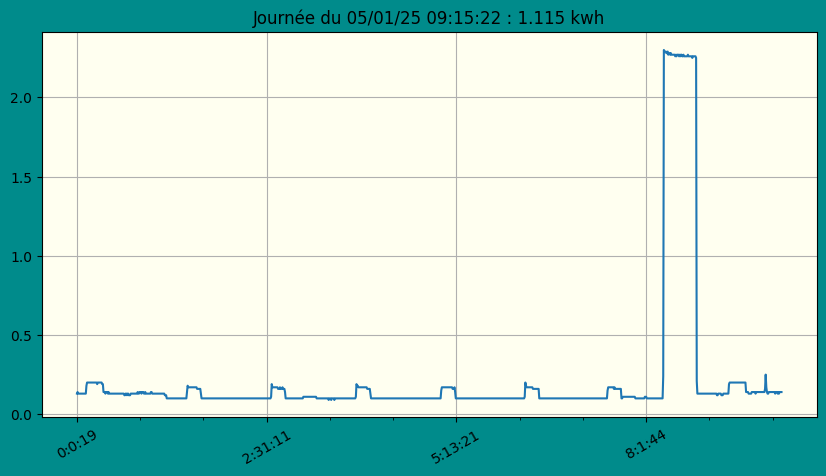

In [100]:
show(today,bgcolor='ivory')

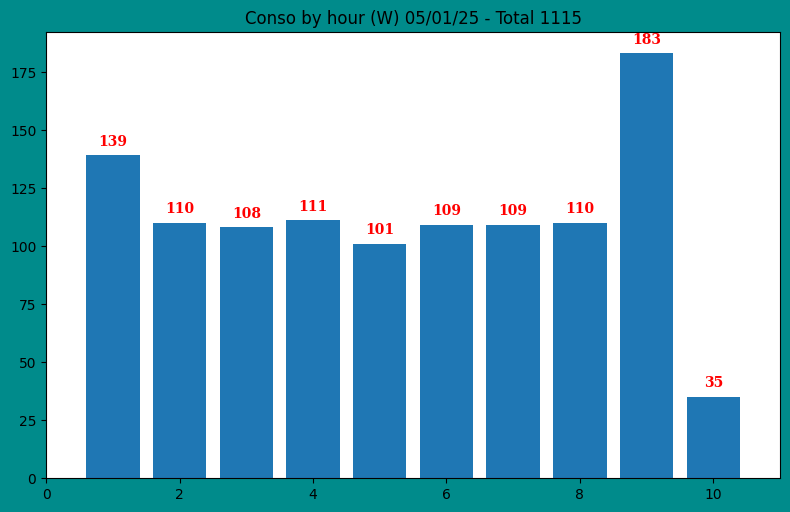

In [101]:
conso_by_hour(today)

In [102]:
day = '03/01/25'

('03/01/25', None)

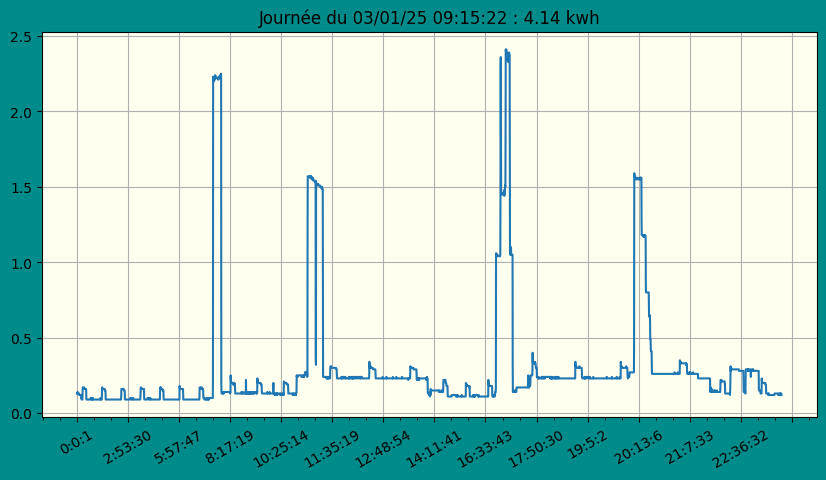

In [103]:
day, show(day,bgcolor='ivory')

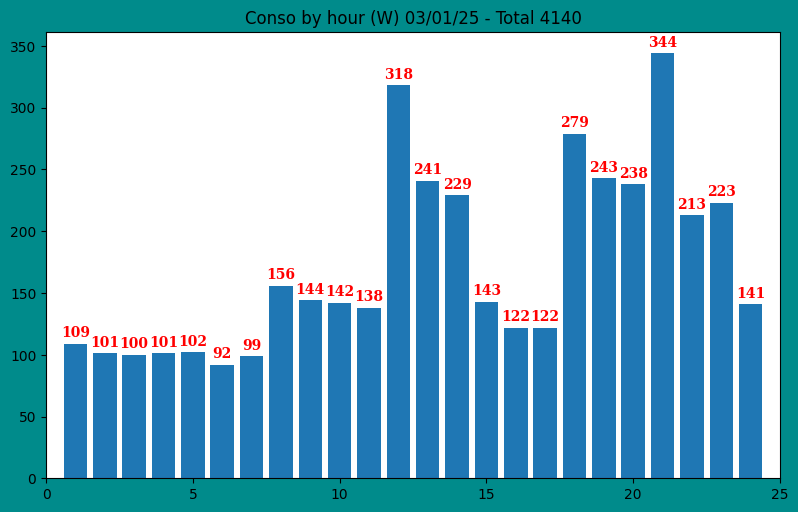

In [104]:
conso_by_hour(day)

In [105]:
maxday

'21/12/23'

('21/12/23', None)

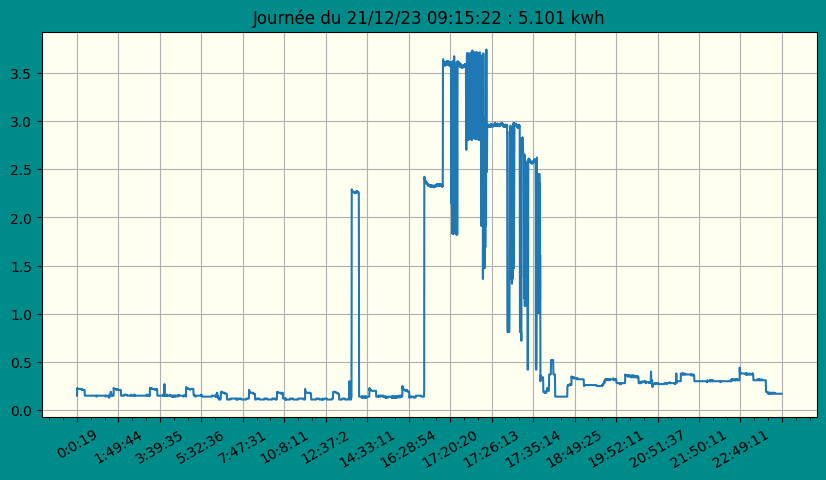

In [106]:
# retour vietnam 22/10/2024
#day = '22/10/24'
day = maxday
day, show(day,bgcolor='ivory')

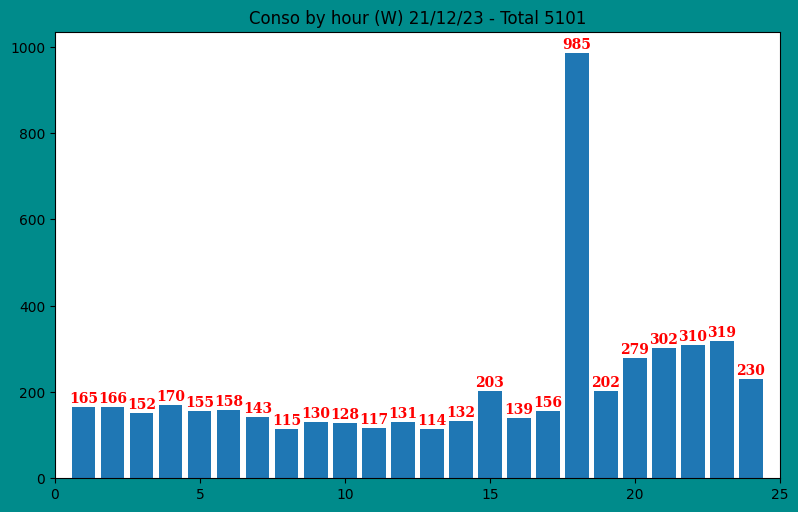

In [107]:
conso_by_hour(day)

In [108]:
sum(data)

5101

In [109]:
diff = grp_by_dayhours.loc[today]
diff


,kWh,cumsum,diff,days
hours,,,,
00,139,139,NaN,1.0
01,110,249,-29.0,2.0
02,108,357,-2.0,3.0
03,111,468,3.0,4.0
04,101,569,-10.0,5.0
05,109,678,8.0,6.0
06,109,787,0.0,7.0
07,110,897,1.0,8.0
08,183,1080,73.0,9.0


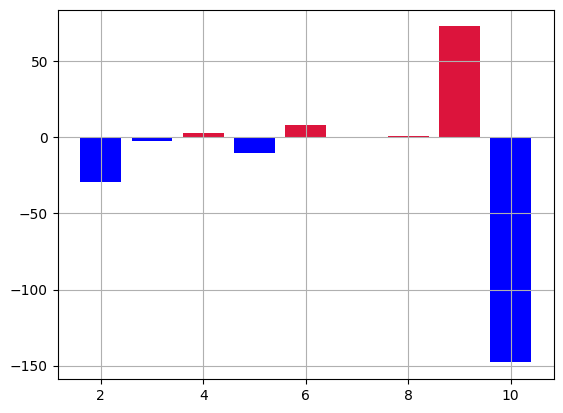

In [110]:
x = np.arange(1,len(diff)+1)

plt.bar(x,diff['diff'], color=np.where(diff['diff'] > 0, 'crimson', 'blue'))
plt.grid()

In [111]:
data

hours
00    165
01    166
02    152
03    170
04    155
05    158
06    143
07    115
08    130
09    128
10    117
11    131
12    114
13    132
14    203
15    139
16    156
17    985
18    202
19    279
20    302
21    310
22    319
23    230
Name: kWh, dtype: int64

<Axes: xlabel='hours'>

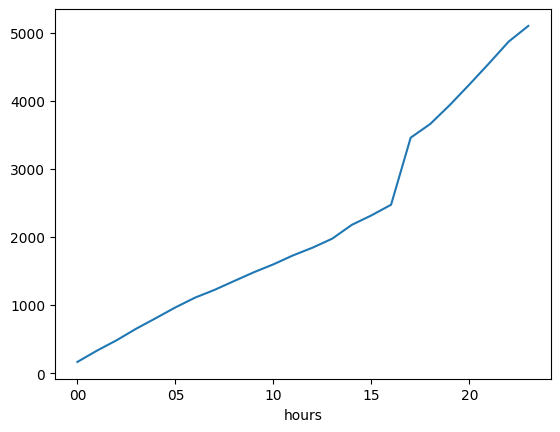

In [112]:
data.cumsum().plot()


<Axes: xlabel='hours'>

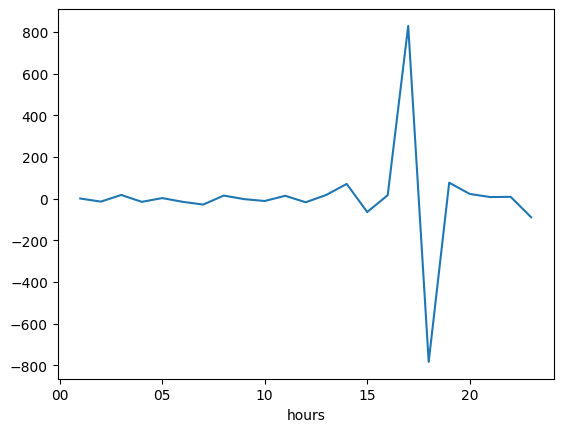

In [113]:
# evolution par heure
data.diff().plot()

In [114]:
data.diff().describe()

count     23.000000
mean       2.826087
std      245.599388
min     -783.000000
25%      -15.000000
50%        3.000000
75%       17.500000
max      829.000000
Name: kWh, dtype: float64

<Axes: >

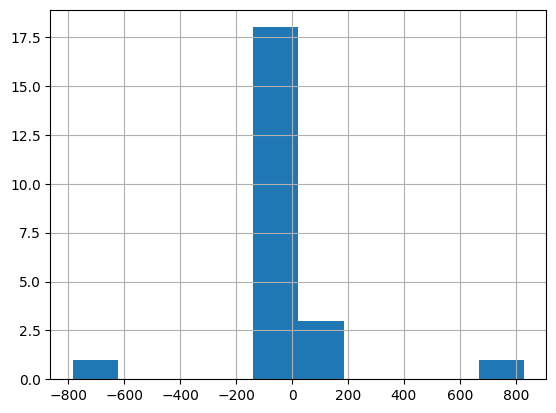

In [115]:
data.diff().hist()

# Test sauvegarde

In [116]:
import os
os.listdir(path='.')

['.git',
 '.gitignore',
 '.ipynb_checkpoints',
 '1row.flf',
 '5_days_meteo.ipynb',
 '8days.csv',
 '8days.pkl',
 '8days_dump.json',
 '8days_to_json.json',
 'advanced_expression.ipynb',
 'alphabeta_tree.ipynb',
 'amlich.ipynb',
 'amlich5.ipynb',
 'amlich_data.py',
 'amlich_functions.py',
 'amlich_lib.py',
 'AntPath.ipynb',
 'Apple.csv',
 'astronomie_def.ipynb',
 'atom_electronic_configuration.ipynb',
 'average_binding_energy_by_nucleons.ipynb',
 'bar_label.ipynb',
 'bell_curve.ipynb',
 'bitcoin_api.ipynb',
 'bitmap_convert.ipynb',
 'bitmap_structure.ipynb',
 'CAC40.csv',
 'chess_board.ipynb',
 'coindesk_api_client.ipynb',
 'collections.ipynb',
 'colormaps.ipynb',
 'conso.txt',
 'conso_by_hour.ipynb',
 'conso_data.csv',
 'conso_day_from_20230821.csv',
 'conso_jour.csv',
 'conso_jour.png',
 'conso_kwh.ipynb',
 'conso_kwh_reduced.ipynb',
 'conso_par_jour.csv',
 'covid19_france.ipynb',
 'cryptography_fernet.ipynb',
 'csv_readwrite.ipynb',
 'curves.ipynb',
 'dash_app001.ipynb',
 'data_correla

In [117]:
# list to store files
res = []
# Iterate directory
for file in os.listdir('.'):
    # check only text files
    if file.endswith('.csv'):
        res.append(file)
        print(file)
#print(res)

8days.csv
Apple.csv
CAC40.csv
conso_data.csv
conso_day_from_20230821.csv
conso_jour.csv
conso_par_jour.csv
data_temp16122022.csv
demain.csv
df.csv
df_grp.csv
DowJones.csv
EURUSD.csv
Ford.csv
karaoke.csv
ligue1_2020_27.csv
Nasdaq.csv
Nikkei.csv
planete.csv
saturn_bodies.csv
saturn_rings.csv
SMSSpamCollection.csv
table-indicateurs-open-data-dep-2023-06-30-17h59.csv
table-indicateurs-open-data-france-2023-06-30-17h59.csv
temp_humidity.csv
Tesla.csv
titanic.csv
Toyota.csv
VNDUSD.csv
WA_Fn-UseC_-Telco-Customer-Churn.csv
week.csv


In [118]:
#conso_byhour(day)

In [119]:
# save to file
import pickle
path = r'../consobyhour.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

# plot any day


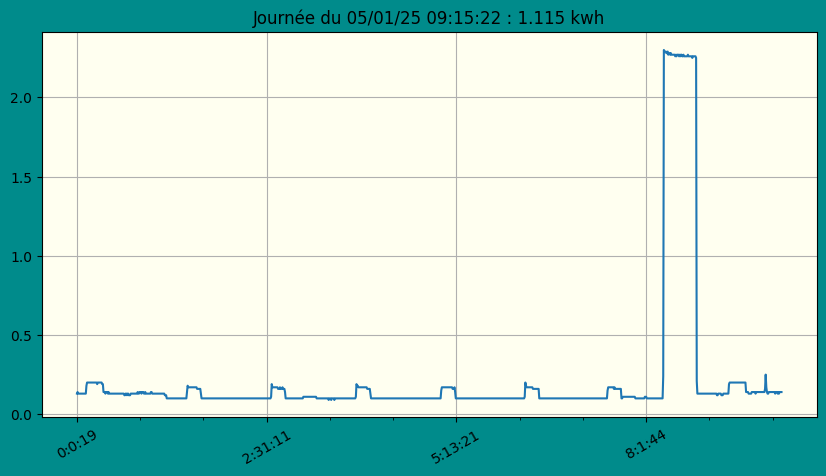

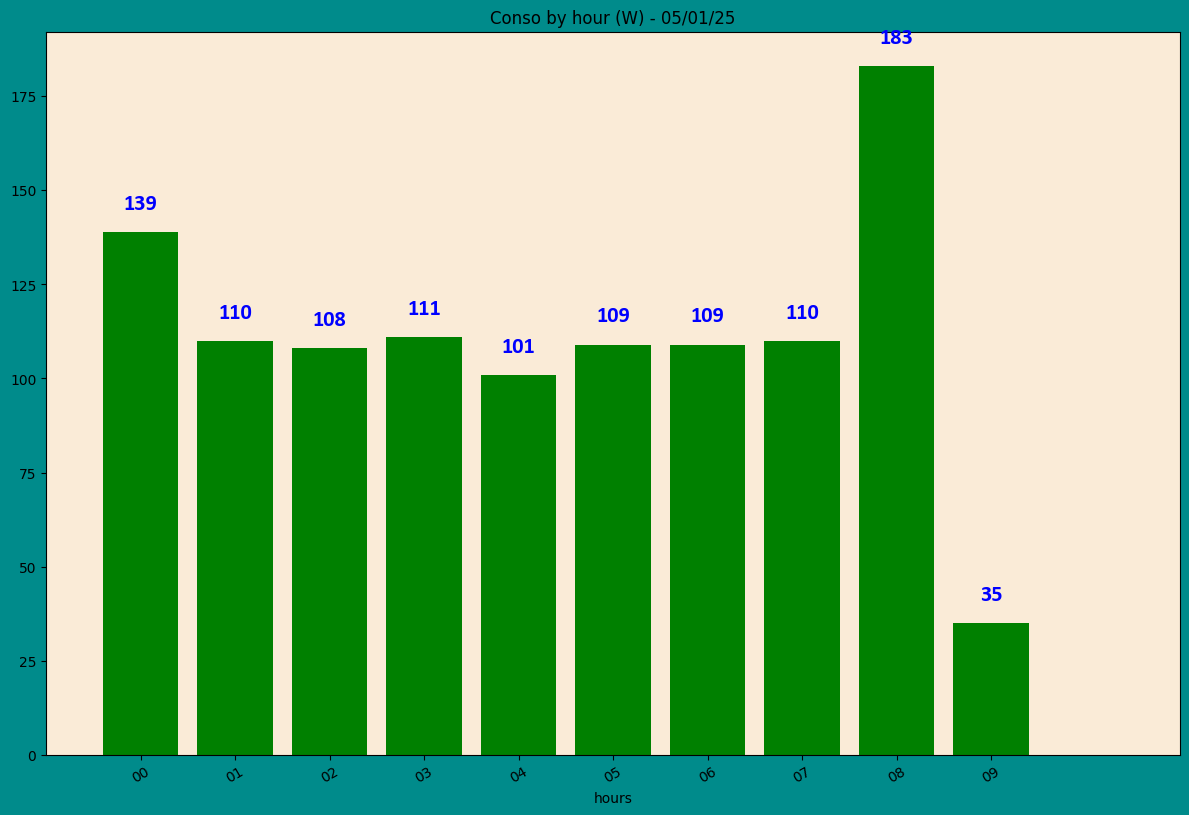

In [120]:
day = '27/10/24'
day = today
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [121]:
month.describe()


count    30.000000
mean      3.696900
std       0.491757
min       3.006000
25%       3.310250
50%       3.545000
75%       3.953250
max       5.075000
Name: kWh, dtype: float64

<Axes: >

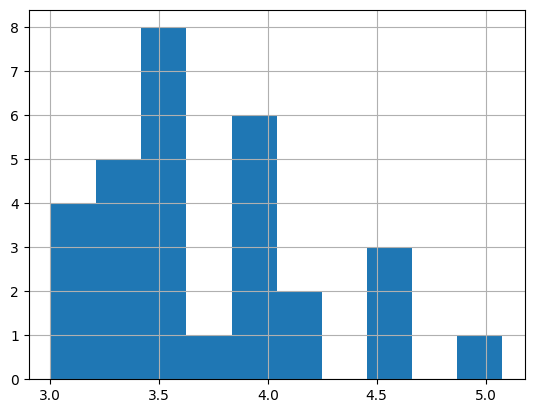

In [122]:
month.hist()

<Axes: xlabel='days'>

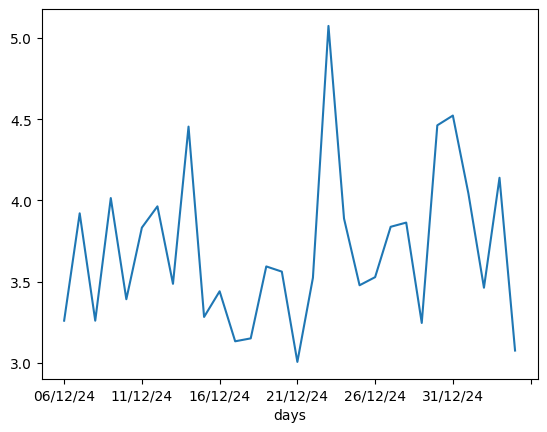

In [123]:
month.plot()

In [124]:
# date with max conso in 1 month
month.idxmax()

'23/12/24'

In [125]:
# plot month day max conso (télévision de 11h à 23h)
day = month.idxmax()
#day = '27/10/2024'
day

'23/12/24'

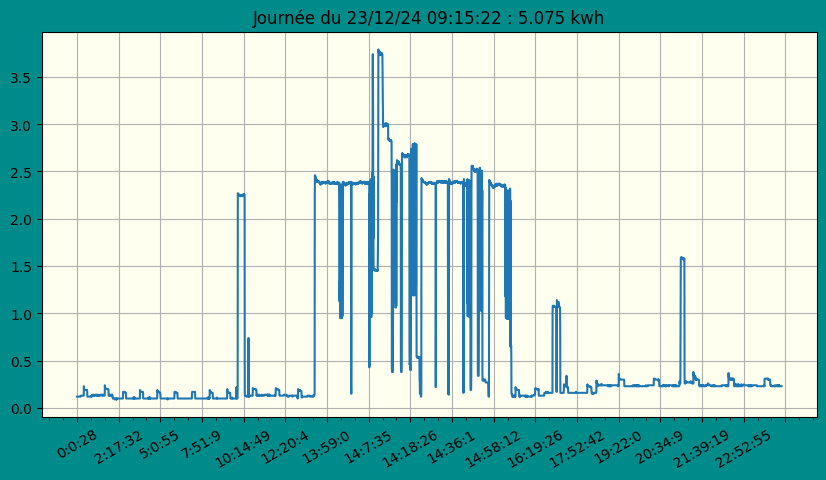

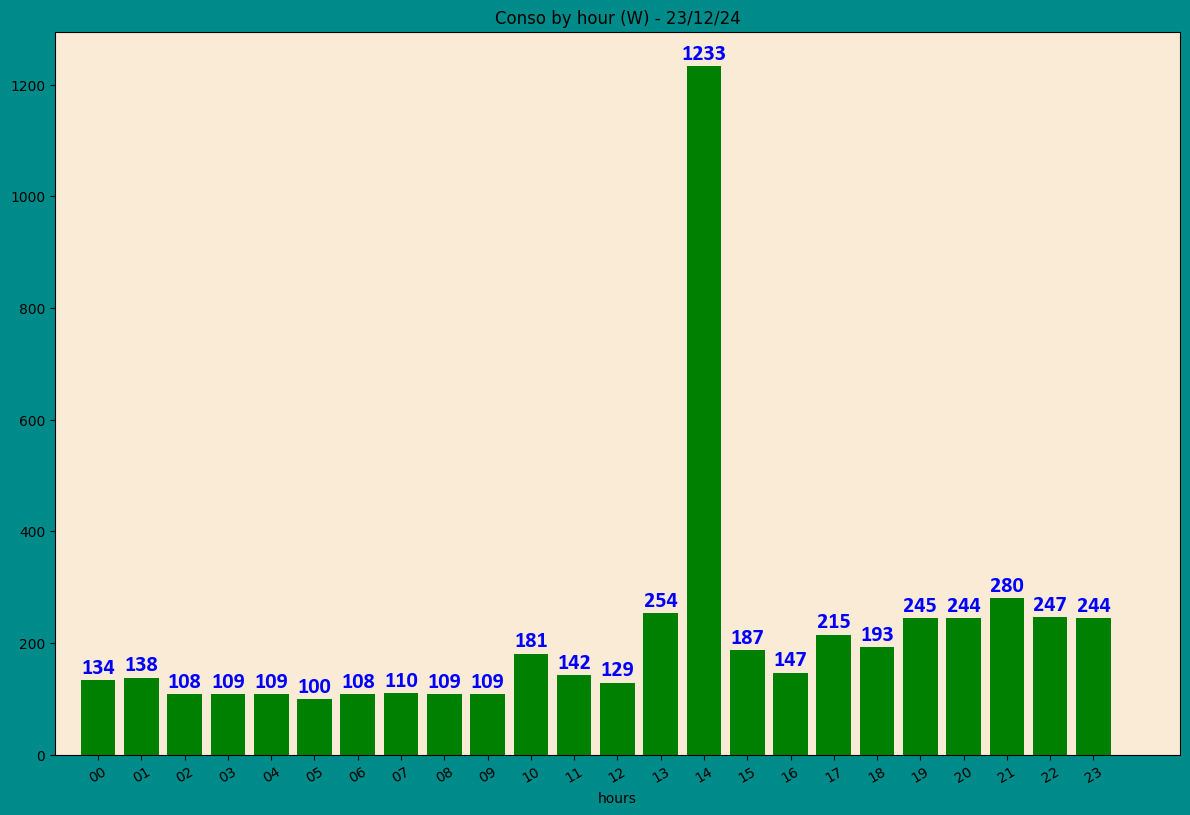

In [126]:
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [127]:
grp_by_dayhours

kWh  cumsum   diff  days
days     hours                          
21/08/23 20     127     127    NaN   NaN
         21     279     406  152.0   NaN
         22     143     549 -136.0   NaN
         23     130     679  -13.0   NaN
22/08/23 00     130     130    NaN   NaN
...             ...     ...    ...   ...
05/01/25 05     109     678    8.0   6.0
         06     109     787    0.0   7.0
         07     110     897    1.0   8.0
         08     183    1080   73.0   9.0
         09      35    1115 -148.0  10.0

[12062 rows x 4 columns]

In [128]:
grp_by_dayhours.loc[month.idxmax()]

,kWh,cumsum,diff,days
hours,,,,
00,134,134,NaN,NaN
01,138,272,4.0,NaN
02,108,380,-30.0,NaN
03,109,489,1.0,NaN
04,109,598,0.0,NaN
05,100,698,-9.0,NaN
06,108,806,8.0,NaN
07,110,916,2.0,NaN
08,109,1025,-1.0,NaN


In [129]:
grp_by_dayhours.columns

Index(['kWh', 'cumsum', 'diff', 'days'], dtype='object')

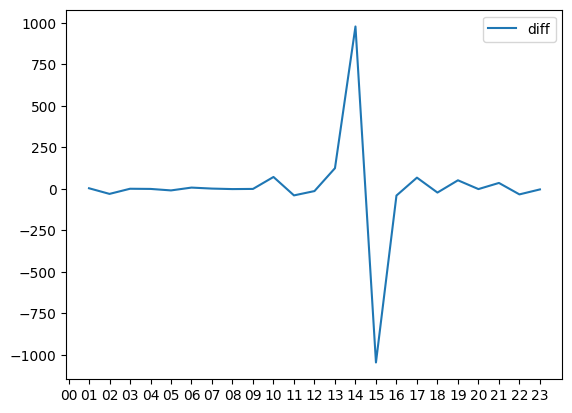

In [130]:
# diff
plt.plot(grp_by_dayhours.loc[month.idxmax()]['diff'],label=grp_by_dayhours.columns[2])
plt.legend()

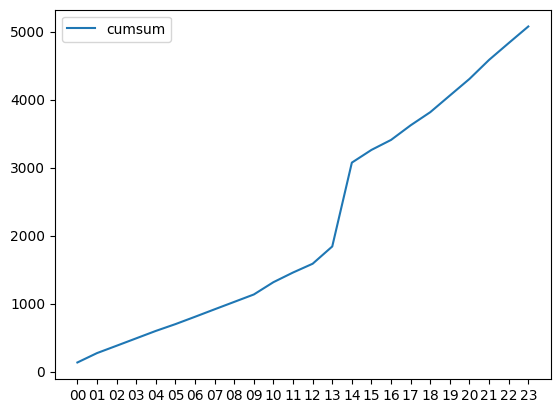

In [131]:
# cumsum
plt.plot(grp_by_dayhours.loc[month.idxmax()]['cumsum'],label=grp_by_dayhours.columns[1])
plt.legend()

In [132]:
# 41 s
# file to big to git sync

# create .gitignore
filename=r'../conso_data.csv'
#conso_data.to_csv(filename)
#43.6s size 140128 kB